In [1]:
import polars as pl
from src.paths import (
    PYTHON_VULNERABILITY_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH,
    PYTHON_CODE_UNITS_DATA_PATH,
    PYTHON_CODE_CONTEXT_DATA_PATH,
)
from tqdm import tqdm
import jedi
import whatthepatch
from git import Repo
from typing import Any
import jedi.api
import jedi.common
import json
import shutil
import logging
import matplotlib.pyplot as plt

from src.process_code_changes import get_changes

## Filter out data

In [2]:
# python_commit_data = commit_data_only_top_langs.filter(pl.col("language") == "Python")
python_vulnerability_fixes = pl.read_parquet(PYTHON_VULNERABILITY_FIXES_DATA_PATH)
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])
python_vulnerability_fixes = python_vulnerability_fixes.group_by('vulnerability_id', 'repo', 'commit', 'pull_request_number', 'file', 'patch', 'patch_time', 'commit_source', 'file_extension', 'language').agg(pl.col("cwe_id"))
python_vulnerability_fixes = python_vulnerability_fixes.unique("patch")
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])


1805
1803


## Filter out data connected with test functionallity

In [3]:
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.contains(r"\/{0,1}[tT][eE][sS][tT][sS]{0,1}\/")
        | pl.col("patch").str.contains("pytest")
        | pl.col("patch").str.contains("unittest")
    ).not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1796

In [4]:
exclude_langs = [
    "txt",
    "md",
    "JSON",
    "YAML",
    "bugfix",
    "cfg",
    "rst",
    "toml",
    "lock",
    "ini",
    "in",
    "gitignore",
    "sample",
    "pem",
    "feature",
    "tif",
    "security",
    "proto",
    "conf",
    "spec",
    "bin",
    "misc",
    "pyi",
    "pxi",
    "fli",
    "gif",
    "tpl",
    "graphql",
    "http",
    "sgi",
    "pyx",
    "inc"
]
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.split(".").list.last().is_in(exclude_langs)
    ).not_(),
    pl.col("file").str.contains(r"__.*__.py").not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1741

## Process missing commit

In [5]:
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
python_vulnerability_fixes = python_vulnerability_fixes.with_columns(
    pl.when(pl.col("pull_request_number") == 24391)
    .then(pl.lit("86664c9405136a4904775c52e6caf100a474ec58"))
    .otherwise(pl.col("commit"))
    .alias("commit")
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
# No changes related to python: https://github.com/pyca/pyopenssl/commit/6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2
# Very big change: https://github.com/transifex/transifex-client/commit/e0d1f8b38ec1a24e2999d63420554d8393206f58
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    ~pl.col("commit").is_in(
        [
            "6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2",
            "e0d1f8b38ec1a24e2999d63420554d8393206f58",
            "5f7496481bd3db1d06a2d2e62c0dce960a1fe12b",
            # Not exists in repo
            "13336272e32872247fa7d17e964ccd88ec8d1376",
            "2bfe358043096fdba9e2a4cf0f5740102b37fd8f",
        ]
    )
)
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    pl.col("file") != "setup.py"
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))

shape: (1, 11)
┌────────────┬────────────┬────────┬────────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ vulnerabil ┆ repo       ┆ commit ┆ pull_reque ┆ … ┆ commit_so ┆ file_exte ┆ language ┆ cwe_id    │
│ ity_id     ┆ ---        ┆ ---    ┆ st_number  ┆   ┆ urce      ┆ nsion     ┆ ---      ┆ ---       │
│ ---        ┆ str        ┆ str    ┆ ---        ┆   ┆ ---       ┆ ---       ┆ str      ┆ list[str] │
│ str        ┆            ┆        ┆ i64        ┆   ┆ str       ┆ str       ┆          ┆           │
╞════════════╪════════════╪════════╪════════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2021-3733  ┆ python/cpy ┆ null   ┆ 24391      ┆ … ┆ github    ┆ py        ┆ Python   ┆ ["CWE-400 │
│            ┆ thon       ┆        ┆            ┆   ┆           ┆           ┆          ┆ "]        │
└────────────┴────────────┴────────┴────────────┴───┴───────────┴───────────┴──────────┴───────────┘
shape: (0, 11)
┌─────────────┬──────┬────────┬─────────────┬───┬────────────

In [6]:
python_vulnerability_fixes.filter(pl.col("vulnerability_id") == "2022-29198").unique("language")

shape: (1, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ vulnerabi ┆ repo      ┆ commit    ┆ pull_requ ┆ … ┆ commit_so ┆ file_exte ┆ language ┆ cwe_id    │
│ lity_id   ┆ ---       ┆ ---       ┆ est_numbe ┆   ┆ urce      ┆ nsion     ┆ ---      ┆ ---       │
│ ---       ┆ str       ┆ str       ┆ r         ┆   ┆ ---       ┆ ---       ┆ str      ┆ list[str] │
│ str       ┆           ┆           ┆ ---       ┆   ┆ str       ┆ str       ┆          ┆           │
│           ┆           ┆           ┆ i64       ┆   ┆           ┆           ┆          ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2022-2919 ┆ tensorflo ┆ ea50a40e8 ┆ null      ┆ … ┆ github    ┆ cc        ┆ C/C++    ┆ ["CWE-20" │
│ 8         ┆ w/tensorf ┆ 4f6bff15a ┆           ┆   ┆           ┆           ┆          ┆ ]         │
│           ┆ low       ┆ 0912728e3 ┆           ┆   ┆           ┆           ┆          ┆           │
│           ┆           ┆ 5b6…      ┆           ┆   ┆           ┆           ┆          ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴──────────┴───────────┘

In [17]:
if PYTHON_CODE_FIXES_DATA_PATH.exists():
    print("Reading code fixes")
    code_unit_changes = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).to_dicts()
else:
    code_unit_changes: list[dict[str, Any]] = []

repos: dict[str, Repo] = {}

grouped_vulnerabilities = (
    python_vulnerability_fixes.group_by(
        "repo", "vulnerability_id", "commit", "commit_source", "cwe_id"
    )
    .agg(pl.col("patch"), pl.col("file"), pl.col("language"))
    .sample(fraction=1, shuffle=True)
)
errors: list[dict[str, Any]] = []
checked_commits = set([change["commit"] for change in code_unit_changes])


vulnerabilities_to_check = grouped_vulnerabilities.to_dicts()


for commit_data_row in tqdm(vulnerabilities_to_check):
    if commit_data_row["commit"] in checked_commits:
        continue
    try:
        get_changes(commit_data_row)
    except Exception as e:
        logging.exception(f"Error in {commit_data_row}")

Reading code fixes


  0%|          | 2/2235 [00:02<49:52,  1.34s/it]ERROR:src.process_code_changes:Error processing commit 82b6ce28389f0a317bc55ba2091a74b346db7cae
ERROR:src.process_code_changes:{'repo': 'pyca/cryptography', 'vulnerability_id': '2020-36242', 'commit': '82b6ce28389f0a317bc55ba2091a74b346db7cae', 'commit_source': 'github', 'cwe_id': ['CWE-190', 'CWE-787'], 'patch': ['@@ -17,7 +17,7 @@\n class _CipherContext(object):\n     _ENCRYPT = 1\n     _DECRYPT = 0\n-    _MAX_CHUNK_SIZE = 2 ** 31 - 1\n+    _MAX_CHUNK_SIZE = 2 ** 30 - 1\n \n     def __init__(self, backend, cipher, mode, operation):\n         self._backend = backend', '@@ -71,7 +71,7 @@\n \n # General information about the project.\n project = "Cryptography"\n-copyright = "2013-2020, Individual Contributors"\n+copyright = "2013-2021, Individual Contributors"\n \n # The version info for the project you\'re documenting, acts as replacement for\n # |version| and |release|, also used in various other places throughout the'], 'file': ['src/cr

KeyboardInterrupt: 

In [26]:
new_code_unit_changes = []
new_code_context_changes = []

for commit_data_file in PYTHON_CODE_UNITS_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_unit_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()
for commit_data_file in PYTHON_CODE_CONTEXT_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_context_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()

pl.DataFrame(new_code_unit_changes).write_parquet(PYTHON_CODE_FIXES_DATA_PATH)
pl.DataFrame(new_code_context_changes).write_parquet(PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH)

### Data cleaning

In [32]:
code_unit_changes_df = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH)
code_unit_changes_df = code_unit_changes_df.filter(
    # pl.col("vulnerability_id").is_in(excluded_vulns).not_(),
    pl.col("new_file") != "setup.py",
    pl.col("old_file") != "setup.py"
).with_columns(
    pl.col("code_unit_after_fix").str.replace_all(r"\n\s*\n", "\n").alias("code_unit_after_fix"),
    pl.col("code_unit_before_fix").str.replace_all(r"\n\s*\n", "\n").alias("code_unit_before_fix"),
)
code_unit_changes_df.describe()

shape: (9, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ statistic  ┆ commit     ┆ repo      ┆ new_file  ┆ … ┆ vulnerabi ┆ cwe_id ┆ old_file  ┆ code_unit │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---    ┆ ---       ┆ _before_f │
│ str        ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ f64    ┆ str       ┆ ix        │
│            ┆            ┆           ┆           ┆   ┆ str       ┆        ┆           ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ count      ┆ 1954       ┆ 1954      ┆ 1954      ┆ … ┆ 1954      ┆ 1954.0 ┆ 1954      ┆ 1954      │
│ null_count ┆ 0          ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0    ┆ 0         ┆ 0         │
│ mean       ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ std        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ min        ┆ 001b0634cd ┆ ASKBOT/as ┆ .devconta ┆ … ┆ 2013-0208 ┆ null   ┆ .devconta ┆           │
│            ┆ 309e372edb ┆ kbot-deve ┆ iner/libr ┆   ┆           ┆        ┆ iner/libr ┆           │
│            ┆ 6d7d95d083 ┆ l         ┆ ary-scrip ┆   ┆           ┆        ┆ ary-scrip ┆           │
│            ┆ …          ┆           ┆ ts/…      ┆   ┆           ┆        ┆ ts/…      ┆           │
│ 25%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ 50%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ 75%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ max        ┆ ff704b12e6 ┆ zulip/zul ┆ zproject/ ┆ … ┆ GHSA-x563 ┆ null   ┆ zproject/ ┆ {{ commun │
│            ┆ fa351aaedd ┆ ip        ┆ backends. ┆   ┆ -6hqv-26m ┆        ┆ backends. ┆ ity.descr │
│            ┆ 07bffdc917 ┆           ┆ py        ┆   ┆ r         ┆        ┆ py        ┆ iption|sa │
│            ┆ …          ┆           ┆           ┆   ┆           ┆        ┆           ┆ fe …      │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴────────┴───────────┴───────────┘

In [33]:
code_unit_changes_df = code_unit_changes_df.filter(
    ((pl.col("code_unit_after_fix").str.strip_chars() == "") & (pl.col("code_unit_before_fix").str.strip_chars() == "")).not_(), 
)
code_unit_changes_df.describe()

shape: (9, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ statistic  ┆ commit     ┆ repo      ┆ new_file  ┆ … ┆ vulnerabi ┆ cwe_id ┆ old_file  ┆ code_unit │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---    ┆ ---       ┆ _before_f │
│ str        ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ f64    ┆ str       ┆ ix        │
│            ┆            ┆           ┆           ┆   ┆ str       ┆        ┆           ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ count      ┆ 1948       ┆ 1948      ┆ 1948      ┆ … ┆ 1948      ┆ 1948.0 ┆ 1948      ┆ 1948      │
│ null_count ┆ 0          ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0    ┆ 0         ┆ 0         │
│ mean       ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ std        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ min        ┆ 001b0634cd ┆ ASKBOT/as ┆ .devconta ┆ … ┆ 2013-0208 ┆ null   ┆ .devconta ┆           │
│            ┆ 309e372edb ┆ kbot-deve ┆ iner/libr ┆   ┆           ┆        ┆ iner/libr ┆           │
│            ┆ 6d7d95d083 ┆ l         ┆ ary-scrip ┆   ┆           ┆        ┆ ary-scrip ┆           │
│            ┆ …          ┆           ┆ ts/…      ┆   ┆           ┆        ┆ ts/…      ┆           │
│ 25%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ 50%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ 75%        ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆ null      ┆ null      │
│ max        ┆ ff704b12e6 ┆ zulip/zul ┆ zproject/ ┆ … ┆ GHSA-x563 ┆ null   ┆ zproject/ ┆ {{ commun │
│            ┆ fa351aaedd ┆ ip        ┆ backends. ┆   ┆ -6hqv-26m ┆        ┆ backends. ┆ ity.descr │
│            ┆ 07bffdc917 ┆           ┆ py        ┆   ┆ r         ┆        ┆ py        ┆ iption|sa │
│            ┆ …          ┆           ┆           ┆   ┆           ┆        ┆           ┆ fe …      │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴────────┴───────────┴───────────┘

In [34]:
print(code_unit_changes_df.filter(
    pl.col("code_unit_after_fix") == pl.col("code_unit_before_fix")
).select("commit", "repo").to_dicts())

[{'commit': '67c4b2cc98ae87cf1fa7df4f97fd81b40c79b895', 'repo': 'corydolphin/flask-cors'}, {'commit': '12d31c653c0254fa9d9853f66b04ea46e7397255', 'repo': 'Kozea/CairoSVG'}, {'commit': 'fd70379733c57c6368cc022ac1f841b7b426db7b', 'repo': 'bentoml/bentoml'}, {'commit': '5319cfbe14951e007ccdb323257e5ada869b35d5', 'repo': 'vyperlang/vyper'}, {'commit': '698e01511f62a3c185754db78ebce0eee1f0184d', 'repo': 'tensorflow/tensorflow'}, {'commit': 'ea39375e62f9b8f18e2ca798a5c0fb8c972b7eaa', 'repo': 'delgan/loguru'}, {'commit': '4d8599e8b0520ff4226fbad72f724afae50fdd08', 'repo': 'apache/airflow'}]


In [35]:
sorted(code_unit_changes_df.with_columns(
    pl.col("new_file").str.split(".").list.last().alias("lang")
).group_by("vulnerability_id").agg("lang").with_columns(pl.col("lang").list.unique()).unique("lang").filter(pl.col("lang").list.contains("py").not_()).select("vulnerability_id").to_series().to_list())

['2018-10861',
 '2021-27138',
 '2021-28359',
 '2021-41104',
 '2021-41206',
 '2022-25882',
 '2022-35999',
 '2022-41893',
 '2022-4526',
 '2023-28366',
 '2024-21485',
 '2024-32979',
 '2024-47077',
 '2024-8948']

In [36]:
import os
import tempfile


def try_convert_to_python3(code: str) -> str:
    try:
        with tempfile.TemporaryFile("w") as temp_file:
            temp_file.write(code)
            temp_file.seek(0)
            
            os.system(f"2to3 -w {temp_file.name}")
            return temp_file.readlines()
    except:
        return code
            

total = 0
errors_count = 0
bad_commits = set()
for row in code_unit_changes_df.sample(fraction=1, shuffle=True).iter_rows(named=True):
    file_extension = row["new_file"].split(".")[-1]
    if file_extension in {"py", "pyi", "pyx", "pxi"}:
        total += 1
        script = jedi.Script(code=row["code_unit_after_fix"])
        errors = script.get_syntax_errors()
        if errors and row["commit"]:
            # python3_code = try_convert_to_python3(row["code_unit_after_fix"])
            # script = jedi.Script(code=python3_code)
            # errors = script.get_syntax_errors()
            # if not errors:
            #     continue
            
            # # shutil.rmtree(PYTHON_CODE_UNITS_DATA_PATH / row["commit"], ignore_errors=True)
            # # shutil.rmtree(PYTHON_CODE_CONTEXT_DATA_PATH / row["commit"], ignore_errors=True)
            # print(row["vulnerability_id"], row["repo"], row["new_file"], row["commit"])
            # print(row["code_unit_after_fix"])
            # print(errors)
            # break
            bad_commits.add(row["commit"])
            errors_count += 1

print(errors_count, total)

76 1455


### Duplicate code detection

In [37]:
concated_code_units = pl.concat(
    [code_unit_changes_df.select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    ),
    code_unit_changes_df.select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    )]
)

print(concated_code_units.group_by("code_unit").agg("commit", "repo").filter(pl.col("commit").list.len() > 1).shape[0])


114


#### Filter duplicates in vulnerability

In [38]:
without_duplicates_in_vulnerability = code_unit_changes_df.unique(["vulnerability_id", "code_unit_before_fix", "code_unit_after_fix"])

print(without_duplicates_in_vulnerability.describe())

shape: (9, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ statistic  ┆ commit     ┆ repo      ┆ new_file  ┆ … ┆ vulnerabi ┆ cwe_id ┆ old_file  ┆ code_unit │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---    ┆ ---       ┆ _before_f │
│ str        ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ f64    ┆ str       ┆ ix        │
│            ┆            ┆           ┆           ┆   ┆ str       ┆        ┆           ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ count      ┆ 1700       ┆ 1700      ┆ 1700      ┆ … ┆ 1700      ┆ 1700.0 ┆ 1700      ┆ 1700      │
│ null_count ┆ 0          ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0    ┆ 0         ┆ 0         │
│ mean       ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆

In [ ]:
import subprocess

similarity = []
slice_data = without_duplicates_in_vulnerability.slice(offset=0, length=100)

with tempfile.TemporaryDirectory() as temp_dir:
    for row in slice_data.iter_rows(named=True):
        path = Path(f"{temp_dir}/new_data/{row['commit']}/{row['new_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_after_fix"])
            
        path = Path(f"{temp_dir}/old_data/{row['commit']}/{row['old_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_before_fix"])

    subprocess.check_output(
        "source /Users/somen/Zavodi/unik/duplicate-code-detection-tool/.venv/bin/activate &&"
        f"python -W ignore  duplicate_code_detection.py --json True --file-extensions py -d {temp_dir}/new_data/ {temp_dir}/old_data/",
    )
    
        

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/cy/xkclg4xd0gjglf9yxn33fv6r0000gn/T/tmpbi1yntyr/new_data/b90f10efeb670a2cc877fb88ebb3f2019189e059/joblib/parallel.py'

#### Consistency checks

In [16]:
without_duplicates_in_vulnerability.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix") != ""
).join(
    without_duplicates_in_vulnerability.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix") != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix"))

shape: (0, 4)
┌──────────────────┬──────────────────────┬────────────────────────┬─────────────────────┐
│ vulnerability_id ┆ code_unit_before_fix ┆ vulnerability_id_right ┆ code_unit_after_fix │
│ ---              ┆ ---                  ┆ ---                    ┆ ---                 │
│ str              ┆ str                  ┆ str                    ┆ str                 │
╞══════════════════╪══════════════════════╪════════════════════════╪═════════════════════╡
└──────────────────┴──────────────────────┴────────────────────────┴─────────────────────┘

### Dataset balancing

In [59]:
print(code_unit_changes_df.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200).to_dicts())

VULNERABILITY_TYPES_MAPPING = {
    "CWE-770": "CWE-400",
    "CWE-405": "CWE-400",
    # "CWE-920": "CWE-400",
    "CWE-639": "CWE-863",
    "CWE-290": "CWE-287",
    "CWE-294": "CWE-287",
    "CWE-295": "CWE-287",
    "CWE-306": "CWE-287",
    "CWE-307": "CWE-287",
    "CWE-521": "CWE-287",
    "CWE-522": "CWE-287",
    "CWE-640": "CWE-287",
    "CWE-798": "CWE-287",
    "CWE-77": "CWE-74",
    "CWE-78": "CWE-74",
    # "CWE-88": "CWE-74",
    "CWE-89": "CWE-74",
    # "CWE-91": "CWE-74",
    "CWE-94": "CWE-74",
    # "CWE-917": "CWE-74",
    # "CWE-1236": "CWE-74",
    # "CWE-384": "CWE-610",
    "CWE-601": "CWE-610",
    "CWE-611": "CWE-610",
    "CWE-918": "CWE-610",
    # "CWE-1021": "CWE-610",
    # "CWE-532": "CWE-200",
    "CWE-203": "CWE-200",
    "CWE-208": "CWE-200",
    # "CWE-209": "CWE-200",
    "CWE-532": "CWE-200",
    "CWE-470": "CWE-913",
    "CWE-502": "CWE-913",
    "CWE-1321": "CWE-913",
    "CWE-346": "CWE-345",
    "CWE-347": "CWE-345",
    "CWE-352": "CWE-345",
    "CWE-354": "CWE-345",
    "CWE-924": "CWE-345",
    "CWE-1333": "CWE-407",
    "CWE-312": "CWE-311",
    "CWE-319": "CWE-311",
    "CWE-415": "CWE-672",
    "CWE-416": "CWE-672",
    "CWE-613": "CWE-672",
    "CWE-617": "CWE-670",
    "CWE-838": "CWE-116",
    "CWE-117": "CWE-116",
    "CWE-362": "CWE-367",
    "CWE-125": "CWE-119",
    "CWE-120": "CWE-119",
    "CWE-787": "CWE-119",
    "CWE-662": "CWE-667",
    "CWE-131": "CWE-682",
    "CWE-190": "CWE-682",
    "CWE-191": "CWE-682",
    "CWE-193": "CWE-682",
    "CWE-369": "CWE-682",
    "CWE-444": "CWE-436",
    # ??? CWE-284
    # ??? CWE-285
    # ??? CWE-122
}

# clustered_vulnerabilities = code_unit_changes_df.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by([col for col in code_unit_changes_df.columns if col != "cwe_id"]).agg(pl.col("cwe_id").alias("cwe_id"))
clustered_cwes = code_unit_changes_df.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by("vulnerability_id").agg(pl.col("cwe_id"))
# We filter vulnerabilities, which cwe types are too rare (<100 examples)
cwes_to_exclude = clustered_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 100).select(pl.col("cwe_id")).to_series().to_list()
code_unit_without_rare_cwes = code_unit_changes_df.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).filter(pl.col("cwe_id").is_in(cwes_to_exclude).not_()).group_by("vulnerability_id").agg(pl.col("cwe_id"))
possible_to_sample_cwes = code_unit_without_rare_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200).select("cwe_id").to_series().to_list()
print(possible_to_sample_cwes)

[{'cwe_id': 'CWE-400', 'count': 171}, {'cwe_id': 'CWE-770', 'count': 133}, {'cwe_id': 'CWE-863', 'count': 121}, {'cwe_id': 'CWE-287', 'count': 118}, {'cwe_id': 'CWE-89', 'count': 117}, {'cwe_id': 'CWE-601', 'count': 114}, {'cwe_id': 'CWE-94', 'count': 111}, {'cwe_id': 'CWE-532', 'count': 109}, {'cwe_id': 'CWE-74', 'count': 95}, {'cwe_id': 'CWE-918', 'count': 92}, {'cwe_id': 'CWE-502', 'count': 85}, {'cwe_id': 'CWE-284', 'count': 69}, {'cwe_id': 'CWE-78', 'count': 68}, {'cwe_id': 'CWE-352', 'count': 67}, {'cwe_id': 'CWE-77', 'count': 60}, {'cwe_id': 'CWE-1333', 'count': 59}, {'cwe_id': 'CWE-312', 'count': 53}, {'cwe_id': 'CWE-613', 'count': 52}, {'cwe_id': 'CWE-617', 'count': 48}, {'cwe_id': 'CWE-116', 'count': 47}, {'cwe_id': 'CWE-362', 'count': 46}, {'cwe_id': 'CWE-125', 'count': 44}, {'cwe_id': 'CWE-667', 'count': 41}, {'cwe_id': 'CWE-285', 'count': 41}, {'cwe_id': 'CWE-190', 'count': 40}, {'cwe_id': 'CWE-787', 'count': 38}, {'cwe_id': 'CWE-444', 'count': 37}, {'cwe_id': 'CWE-203', '

## Analyze a relevance of rare cwes

shape: (5_101, 2)
┌─────────────────────┬────────────┐
│ vulnerability_id    ┆ patch_time │
│ ---                 ┆ ---        │
│ str                 ┆ i32        │
╞═════════════════════╪════════════╡
│ 2016-4428           ┆ 2016       │
│ 2023-40587          ┆ 2023       │
│ 2024-32027          ┆ 2024       │
│ GHSA-w235-7p84-xx57 ┆ 2024       │
│ 2024-23637          ┆ 2024       │
│ …                   ┆ …          │
│ 2024-1729           ┆ 2024       │
│ 2024-3126           ┆ 2024       │
│ 2024-24770          ┆ 2024       │
│ 2021-37705          ┆ 2021       │
│ 2024-45201          ┆ 2024       │
└─────────────────────┴────────────┘

In [74]:
vulnerability_year = python_vulnerability_fixes.select("vulnerability_id", "patch_time").with_columns(pl.col("patch_time").cast(pl.Date).dt.year().alias("year"))
vulnerabilities_types_per_year = code_unit_changes_df.join(
    vulnerability_year, on="vulnerability_id", how="left",
).explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).unique(["cwe_id", "vulnerability_id", "year"]).group_by("cwe_id", "year").agg(pl.col("vulnerability_id").count().alias("count")).sort("year")

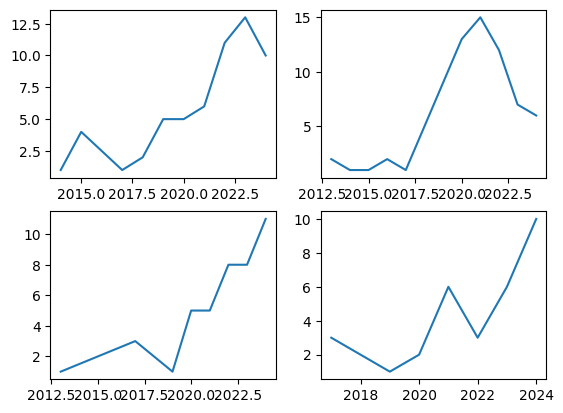

In [78]:
for idx, cwe_id in enumerate(possible_to_sample_cwes):
    data = vulnerabilities_types_per_year.filter(pl.col("cwe_id") == cwe_id).to_pandas()
    plt.subplot(2, 2, idx+1)
    plt.plot(data["year"], data["count"], label=cwe_id)

# data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
# names = list(data.keys())
# values = list(data.values())

# fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# axs[0].bar(names, values)
# axs[1].scatter(names, values)
# axs[2].plot(names, values)
# fig.suptitle('Categorical Plotting')

In [50]:
code_unit_changes_df.explode("cwe_id").filter(pl.col("cwe_id") == "CWE-369").count()

shape: (1, 9)
┌────────┬──────┬──────────┬───────┬───┬──────────────────┬────────┬──────────┬────────────────────┐
│ commit ┆ repo ┆ new_file ┆ patch ┆ … ┆ vulnerability_id ┆ cwe_id ┆ old_file ┆ code_unit_before_f │
│ ---    ┆ ---  ┆ ---      ┆ ---   ┆   ┆ ---              ┆ ---    ┆ ---      ┆ ix                 │
│ u32    ┆ u32  ┆ u32      ┆ u32   ┆   ┆ u32              ┆ u32    ┆ u32      ┆ ---                │
│        ┆      ┆          ┆       ┆   ┆                  ┆        ┆          ┆ u32                │
╞════════╪══════╪══════════╪═══════╪═══╪══════════════════╪════════╪══════════╪════════════════════╡
│ 10     ┆ 10   ┆ 10       ┆ 10    ┆ … ┆ 10               ┆ 10     ┆ 10       ┆ 10                 │
└────────┴──────┴──────────┴───────┴───┴──────────────────┴────────┴──────────┴────────────────────┘